In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import folium
import nltk

In [2]:
import spacy
import re

In [44]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  qq


Command 'qq' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

In [45]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [46]:
# Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import datetime

In [4]:
# Establece la conexión a la base de datos PostgreSQL
conn = psycopg2.connect(
    dbname="panelesweb",
    user="postgres",
    password="paneles0110",
    host="panelesweb-cluster.cluster-ro-cjgme8oigakn.us-east-1.rds.amazonaws.com",
    port="5432"
)

In [5]:
ruta_imagenes = '/home/dario/panelesweb/reportes/'

In [6]:
# Obtener la fecha y hora actual
datetime_actual = datetime.datetime.now()

In [7]:
dia_de_hoy = str(datetime_actual.year) + '-' + str(datetime_actual.month).zfill(2) + '-' + str(datetime_actual.day).zfill(2)

In [8]:
dia_inicio_periodo = '2024-07-01'

In [9]:
sql_mensajes = "select * from rpt_Chat_Detalle where fecha_hora_creacion >= '" + dia_inicio_periodo + "';"
df_mensajes = pd.read_sql(sql_mensajes, conn)

/tmp/ipykernel_10531/1527834639.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mensajes = pd.read_sql(sql_mensajes, conn)


In [10]:
conn.close()

In [11]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [12]:
stopwords.append('hola')
stopwords.append('buenas')
stopwords.append('noches')
stopwords.append('si')
stopwords.append('mil')
stopwords.append('q')
stopwords.remove('por')

In [13]:
nlp = spacy.load('es_core_news_sm')

In [14]:
# Este proceso demora bastante!
mensajes_list=[]
n = 2
for mensaje in df_mensajes.mensaje:
    # Pasamos todo a minúsculas
    mensaje=mensaje.lower()
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    mensaje=re.sub("[^a-záéíóú]"," ",str(mensaje))
    # Tokenizamos para separar las palabras
    mensaje=nltk.word_tokenize(mensaje)
    # Sacamos las Stopwords
    mensaje = [palabra for palabra in mensaje if not palabra in stopwords]
    # Conseguir Ngramas
    ngramas = list(nltk.ngrams(mensaje, n))
    frases = [' '.join(bigram) for bigram in ngramas]
    mensaje = mensaje + frases
    if 'por' in mensaje:
        mensaje.remove('por')
    if 'favor' in mensaje:
        mensaje.remove('favor')
    # Eliminamos las palabras de emenos de 3 letras
    # mensaje = [palabra for palabra in mensaje if len(palabra)>2]
    # Aplico Lematización
    # mensaje = [nlp(palabra) for palabra in mensaje]
    mensajes_list.append(mensaje)    

In [15]:
df_mensajes["mensaje_stem"] = mensajes_list

In [22]:
def genera_grafico(titulo, mensajes_list, ubicacion):
    lista_plana = [str(item) for sublista in mensajes_list for item in sublista]
    mensajes_list_freq = nltk.FreqDist(lista_plana)
    df_mensajes_list_freq = pd.DataFrame(list(mensajes_list_freq.items()), columns = ["Palabra","Frecuencia"])
    df_mensajes_list_freq.sort_values('Frecuencia',ascending=False, inplace = True)
    plt.figure(figsize = (15,8))
    plot = sns.barplot(x  = df_mensajes_list_freq.iloc[:30].Palabra, y = df_mensajes_list_freq.iloc[:30].Frecuencia)
    plt.title(titulo)
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plt.savefig(ubicacion, bbox_inches='tight')
    ##plt.show()

In [19]:
df_mensajes_filtro = df_mensajes[df_mensajes.origen == 'Operador'].mensaje_stem

In [20]:
ubicacion = ruta_imagenes  + 'oficina_todas' + '/rpt_mensajes_operador.png'

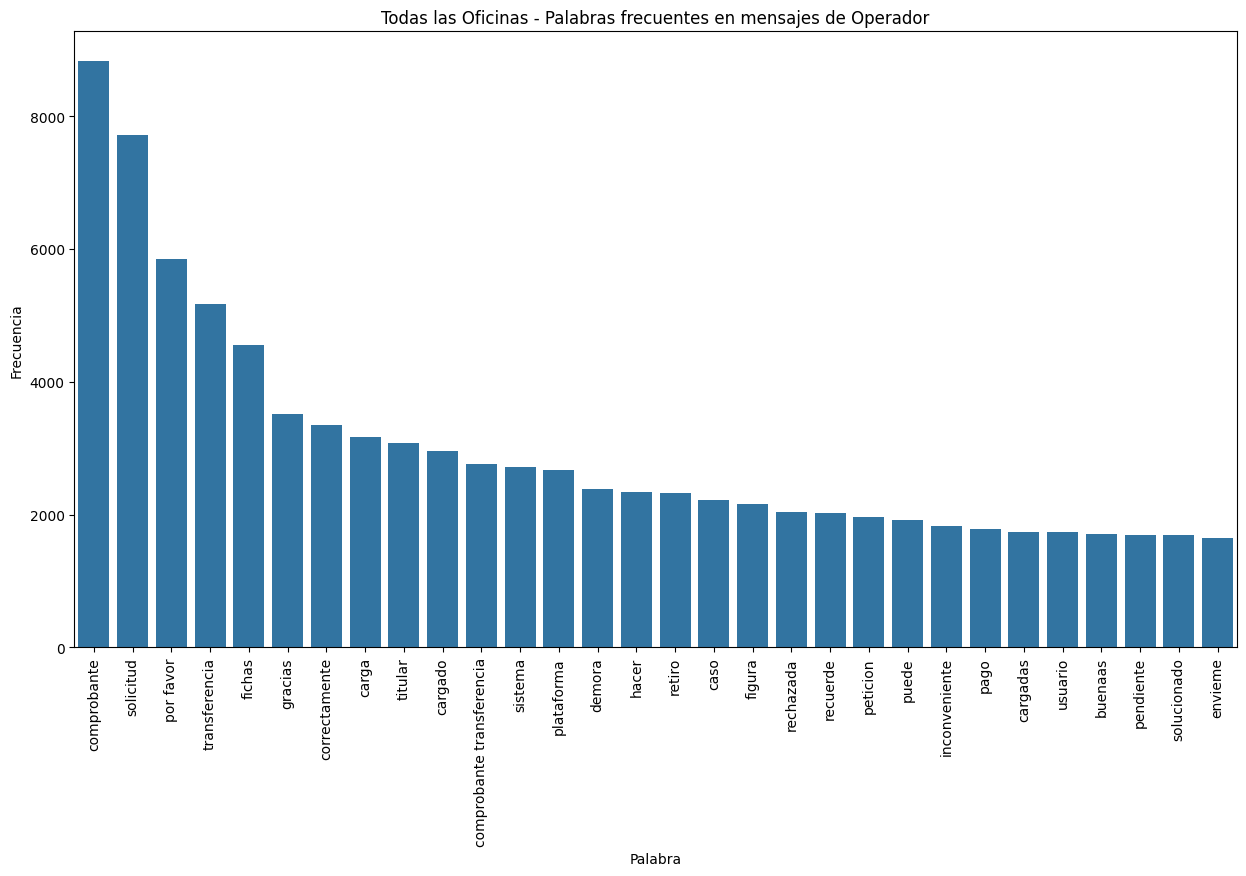

In [23]:
genera_grafico('Todas las Oficinas - Palabras frecuentes en mensajes de Operador', df_mensajes_filtro, ubicacion)

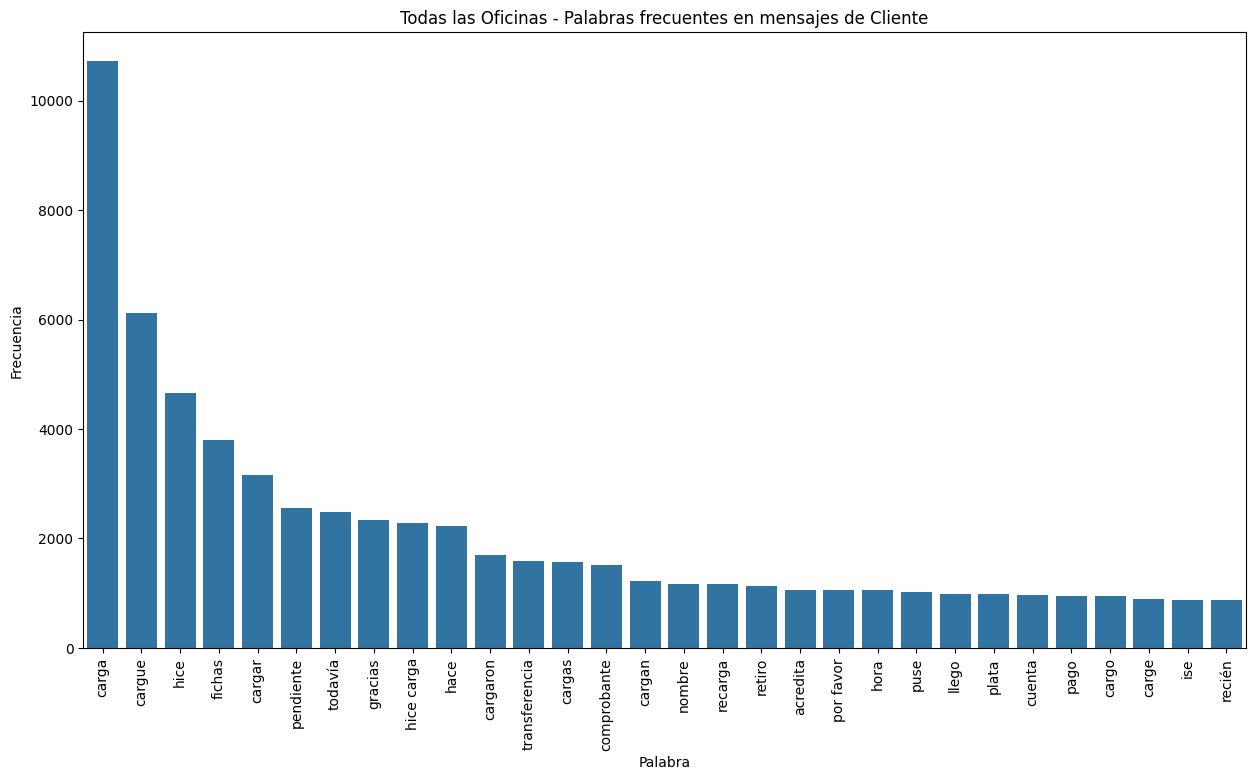

In [24]:
df_mensajes_filtro = df_mensajes[df_mensajes.origen == 'Cliente'].mensaje_stem
ubicacion = ruta_imagenes  + 'oficina_todas' + '/rpt_mensajes_cliente.png'
genera_grafico('Todas las Oficinas - Palabras frecuentes en mensajes de Cliente', df_mensajes_filtro, ubicacion)

In [25]:
df_mensajes.head()

id_oficina  oficina    origen        fecha_hora_creacion  \
0          14  ofirana   Cliente 2024-08-08 02:00:27.318251   
1           8     ofi2   Cliente 2024-07-06 23:20:25.009112   
2           8     ofi2  Operador 2024-07-13 02:57:00.089452   
3          14  ofirana   Cliente 2024-08-08 02:00:38.364543   
4          14  ofirana   Cliente 2024-08-08 02:00:40.602607   

                mensaje                           mensaje_stem  
0                 carge                                [carge]  
1  Ya deposité gracias   [deposité, gracias, deposité gracias]  
2       Hola Buenas 🌊👋🏼                                     []  
3                 8 mil                                     []  
4                 8 mil                                     []

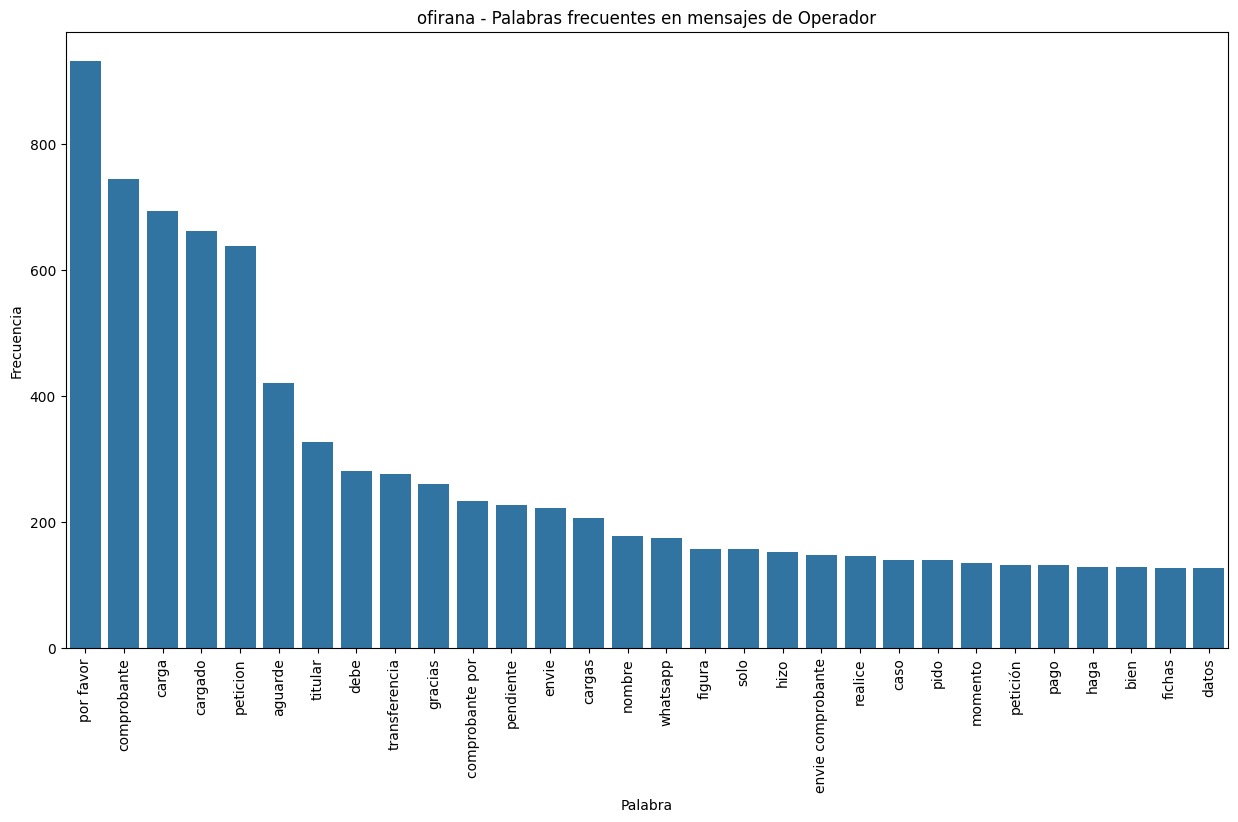

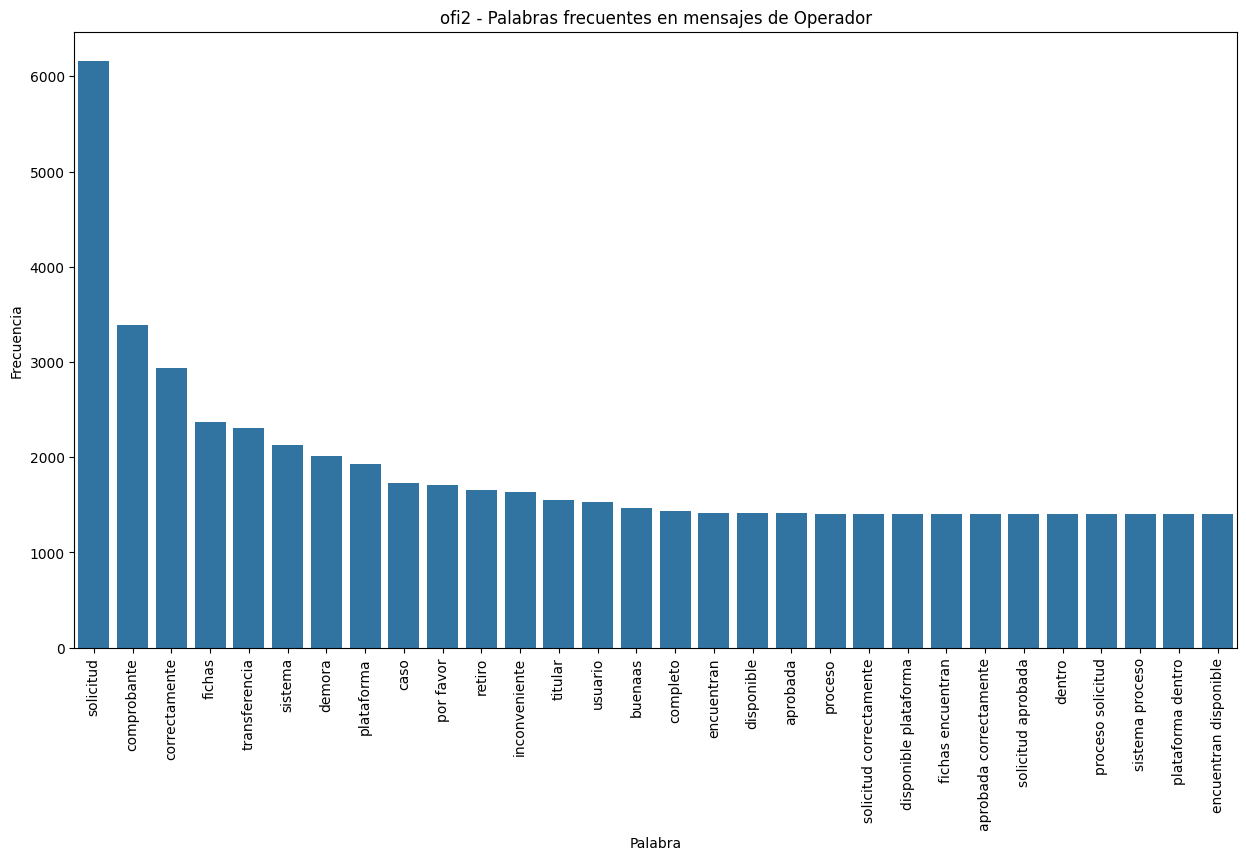

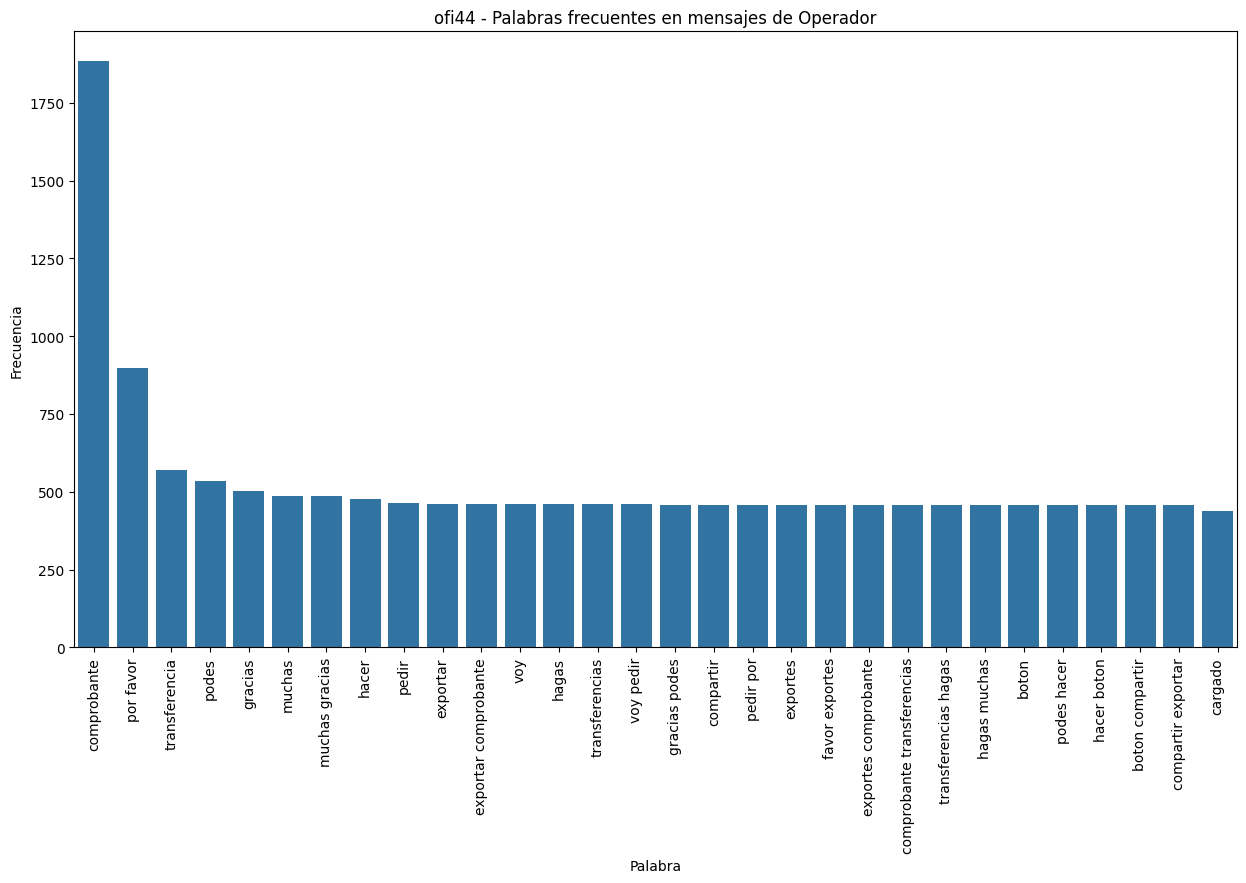

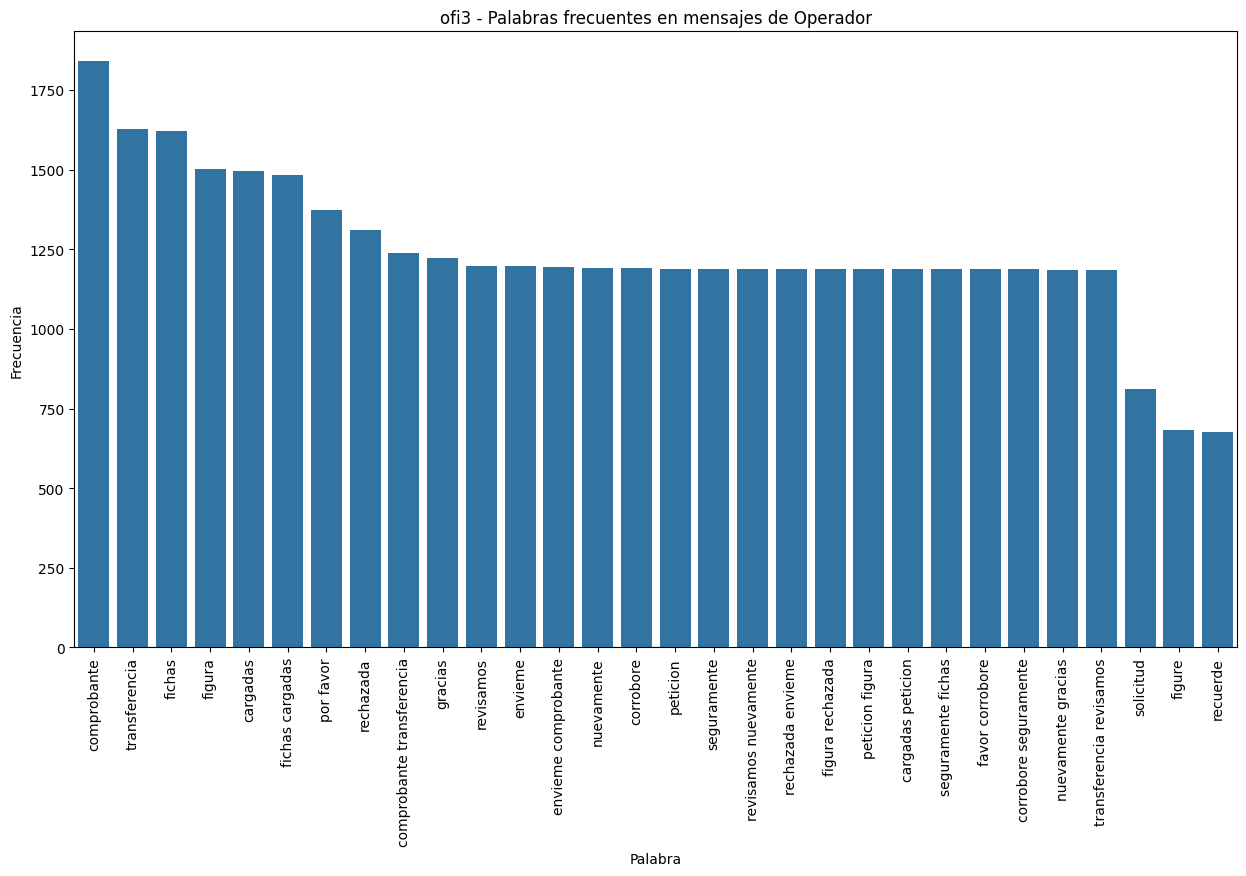

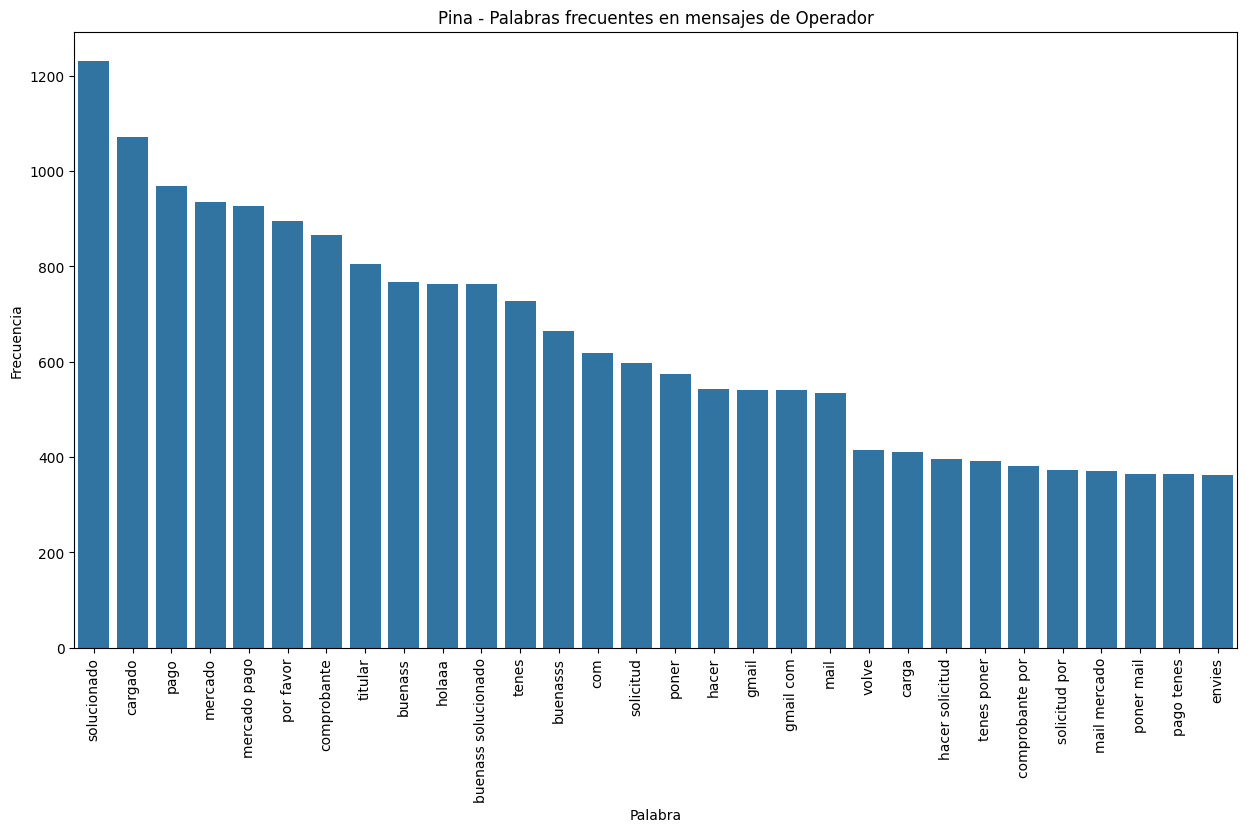

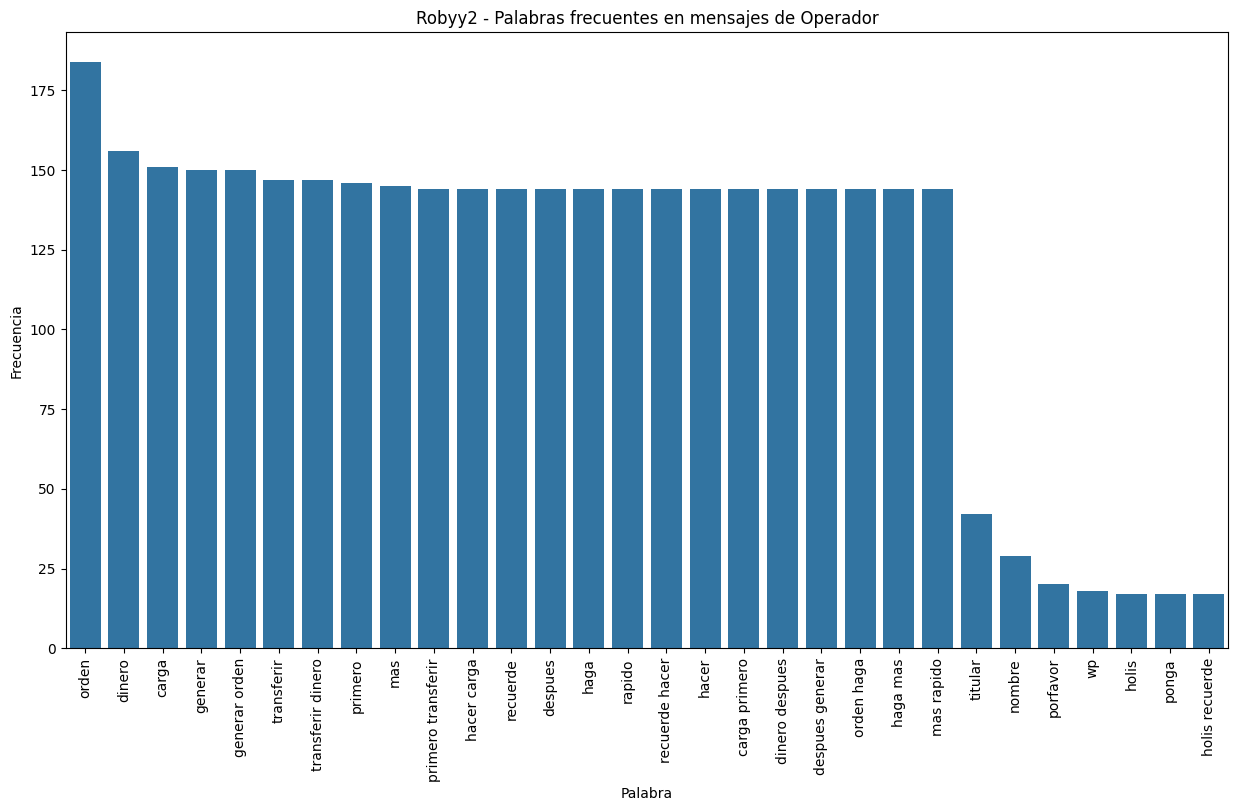

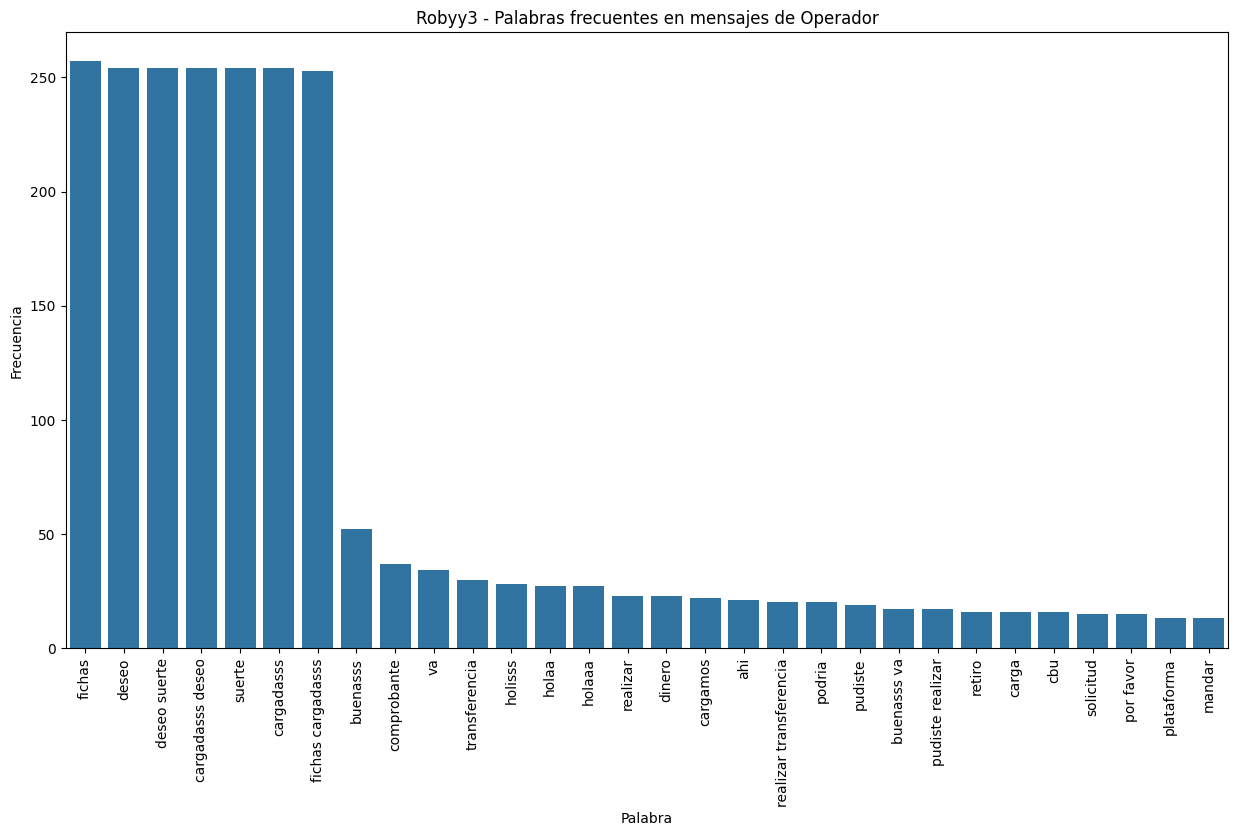

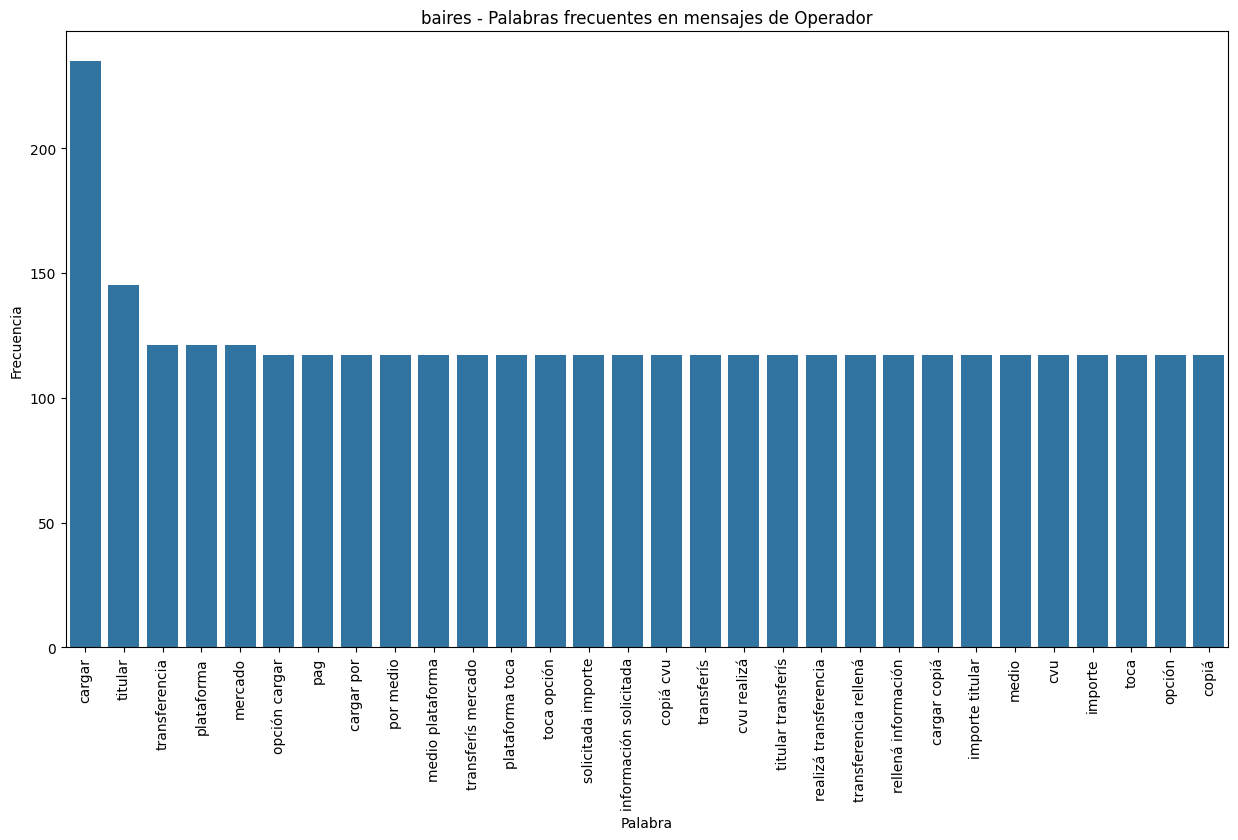

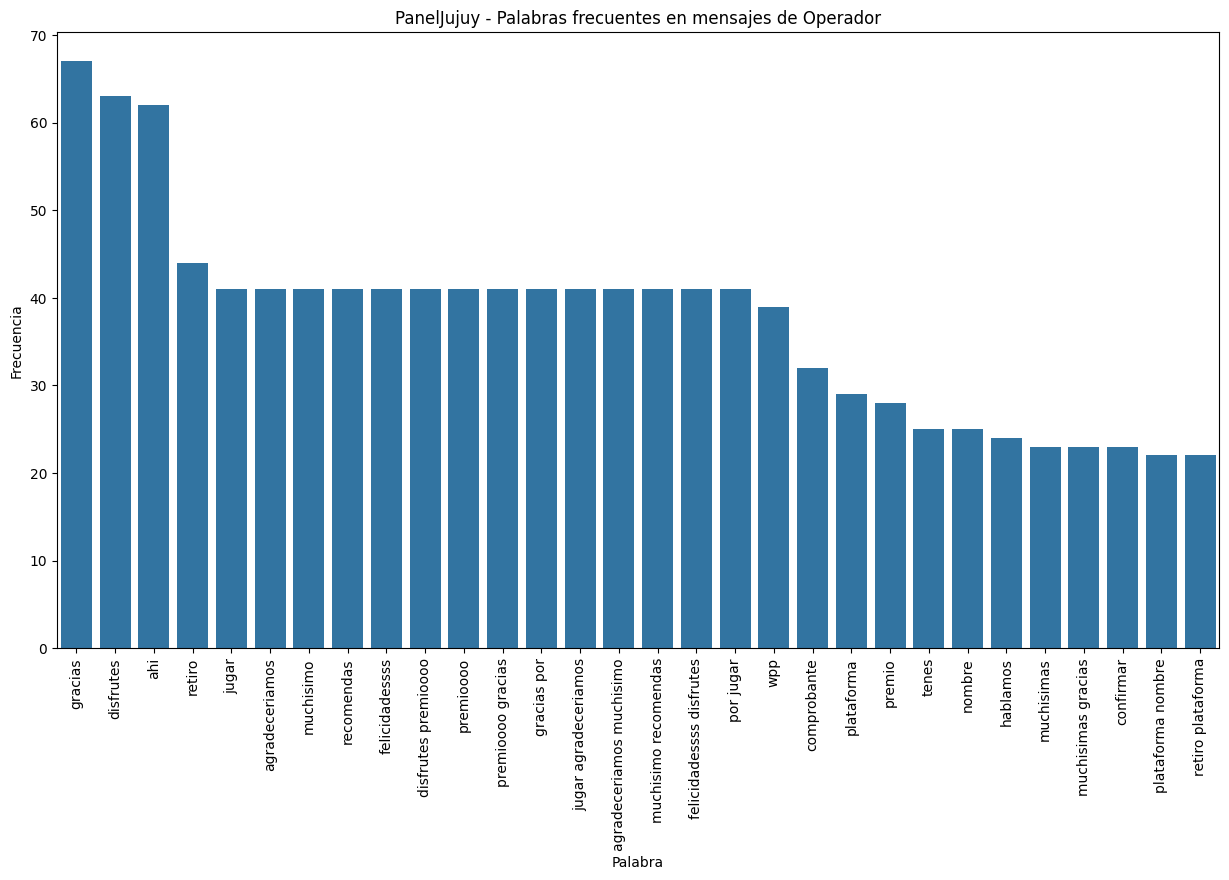

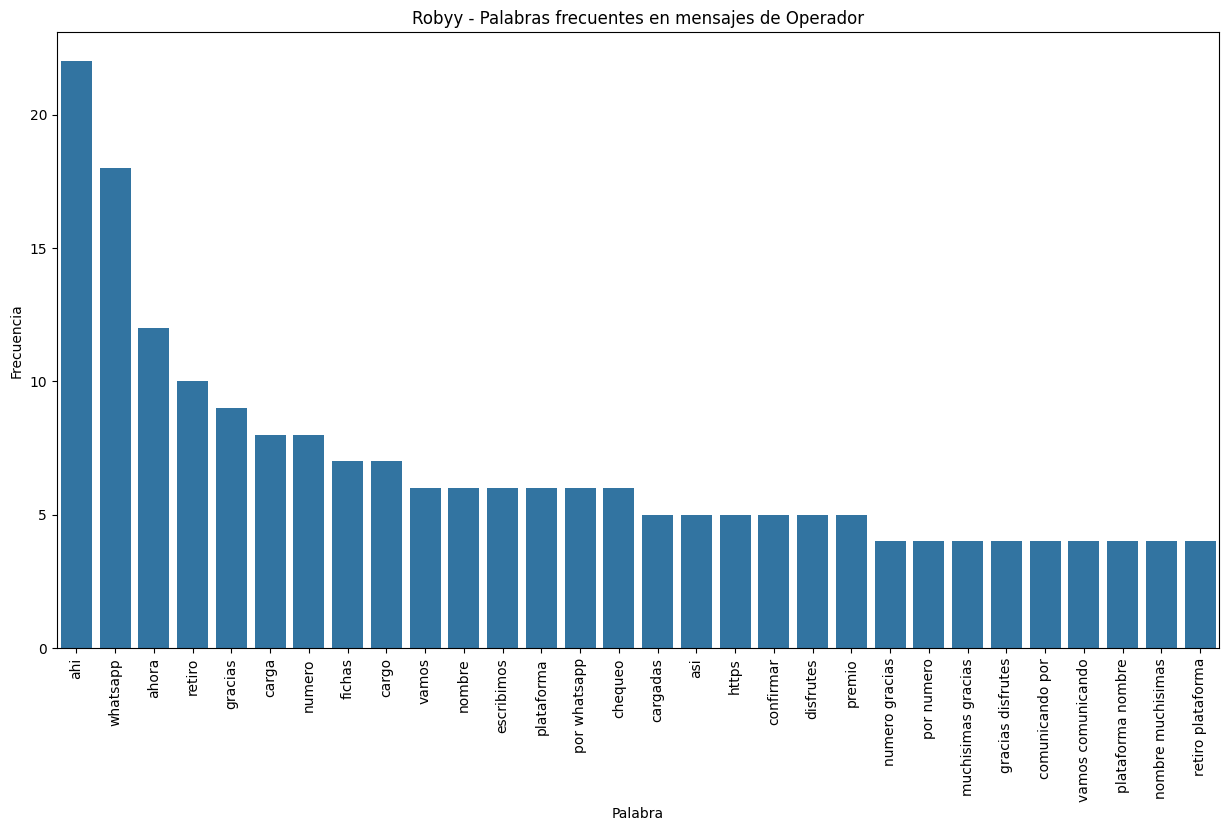

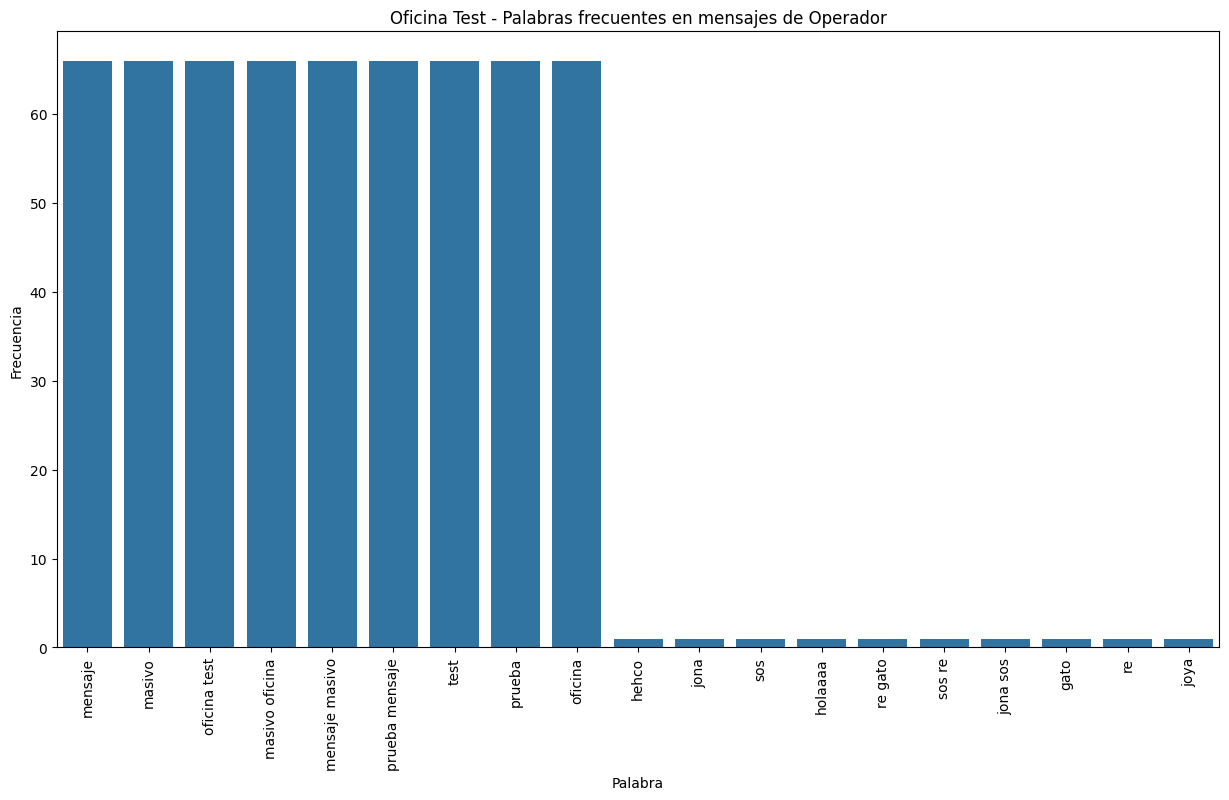

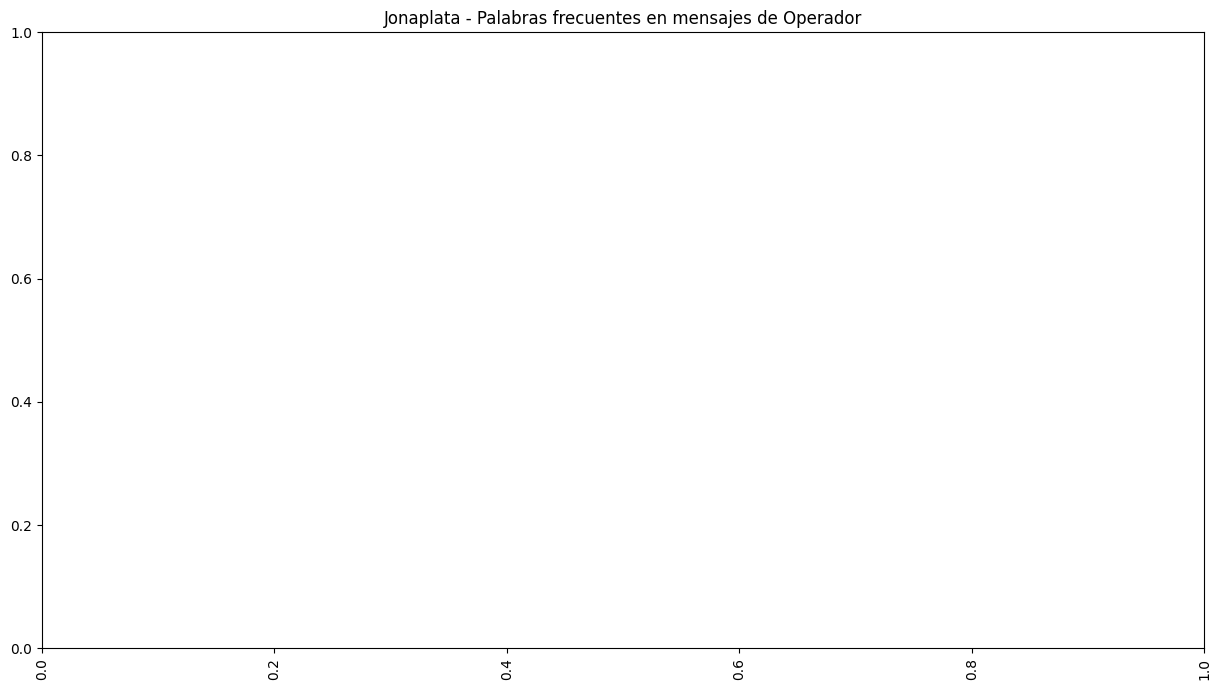

In [27]:
for id_oficina in df_mensajes.id_oficina.unique():
    df_mensajes_filtro = df_mensajes[(df_mensajes.origen == 'Operador') & (df_mensajes.id_oficina == id_oficina) ].mensaje_stem
    ubicacion = ruta_imagenes  + 'oficina_' + str(id_oficina) + '/rpt_mensajes_operador.png'
    oficina = df_mensajes[(df_mensajes.id_oficina == id_oficina)].oficina.unique()[0]
    genera_grafico(oficina + ' - Palabras frecuentes en mensajes de Operador', df_mensajes_filtro, ubicacion)

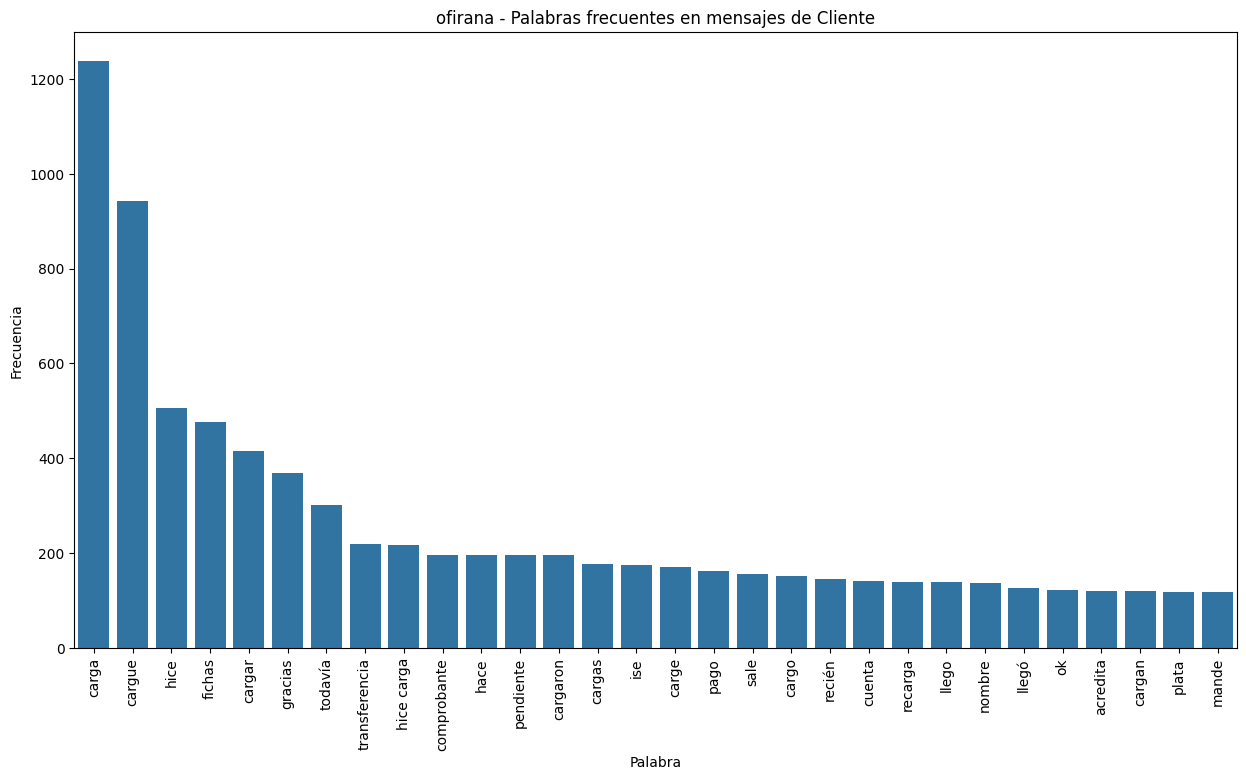

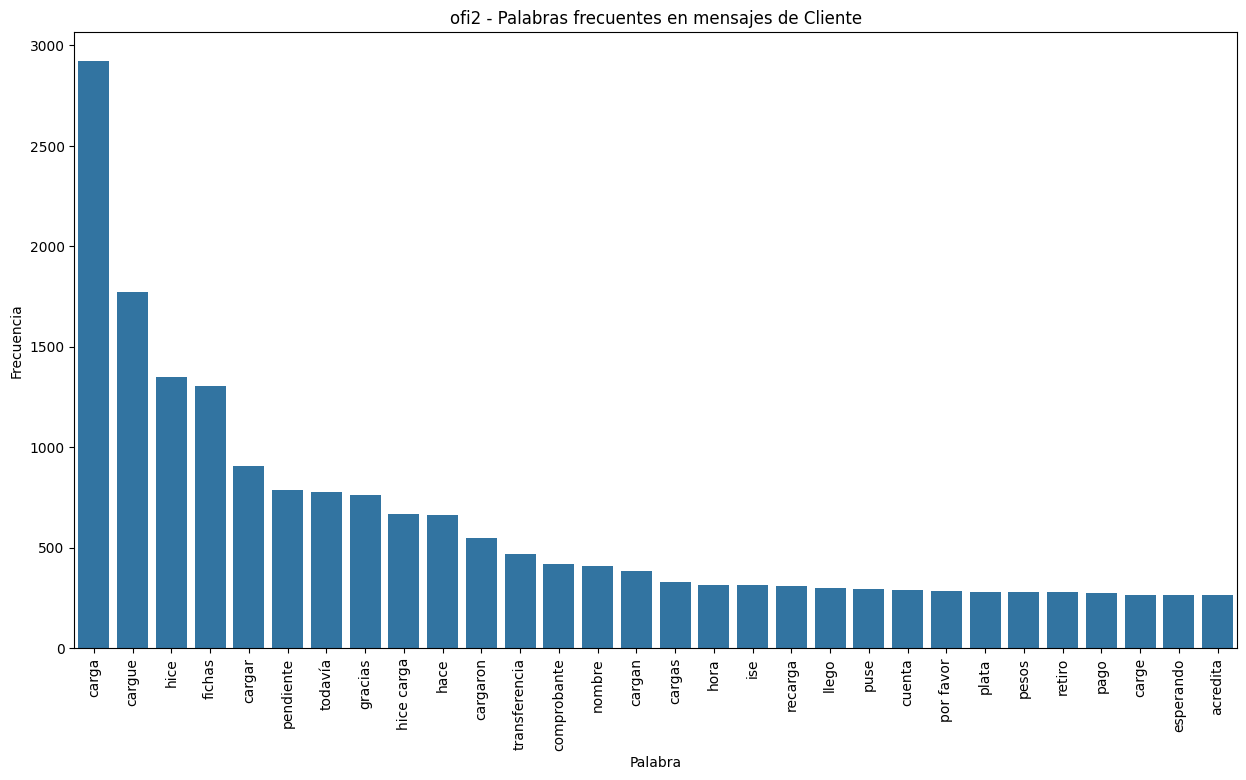

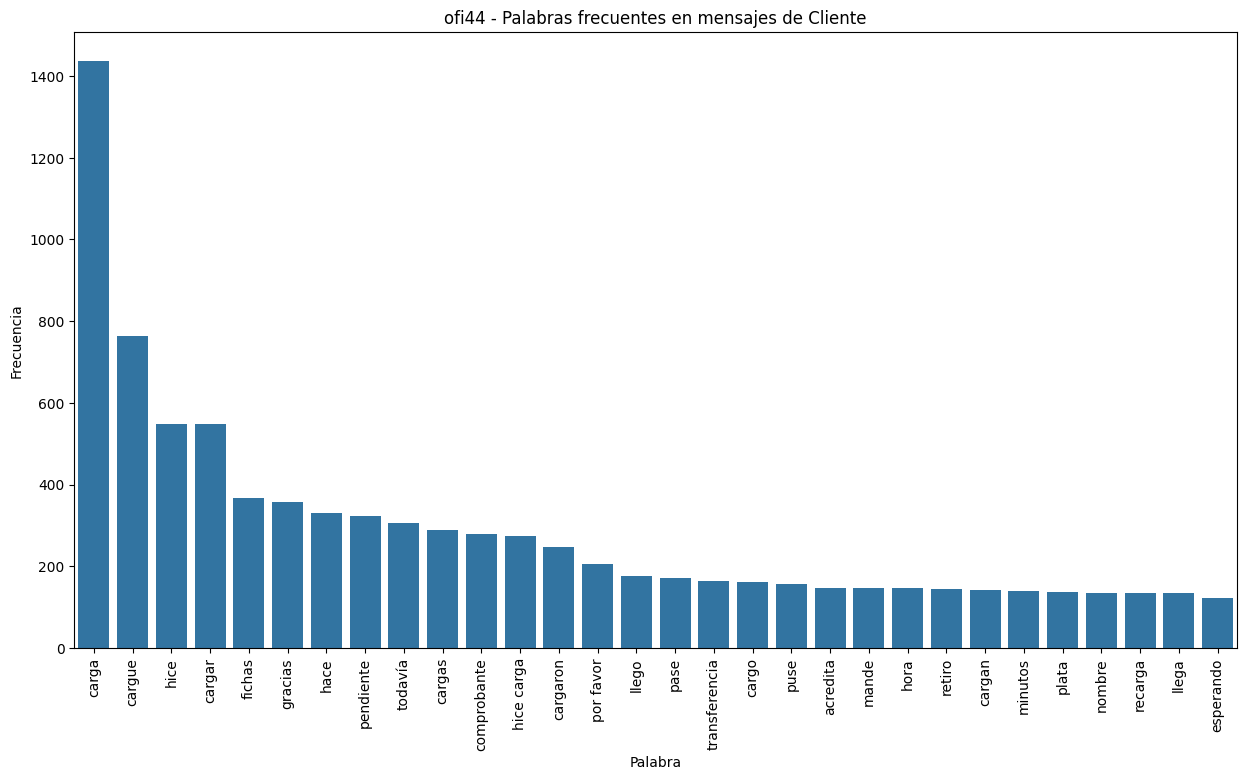

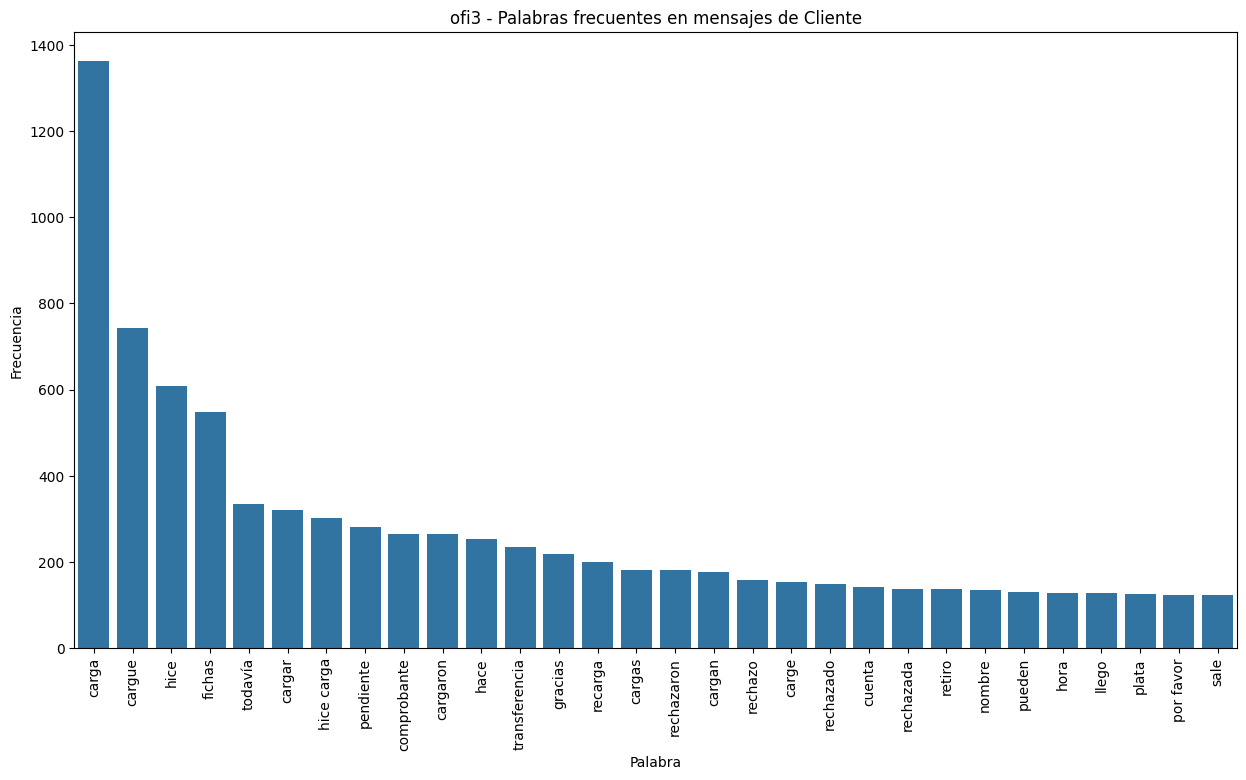

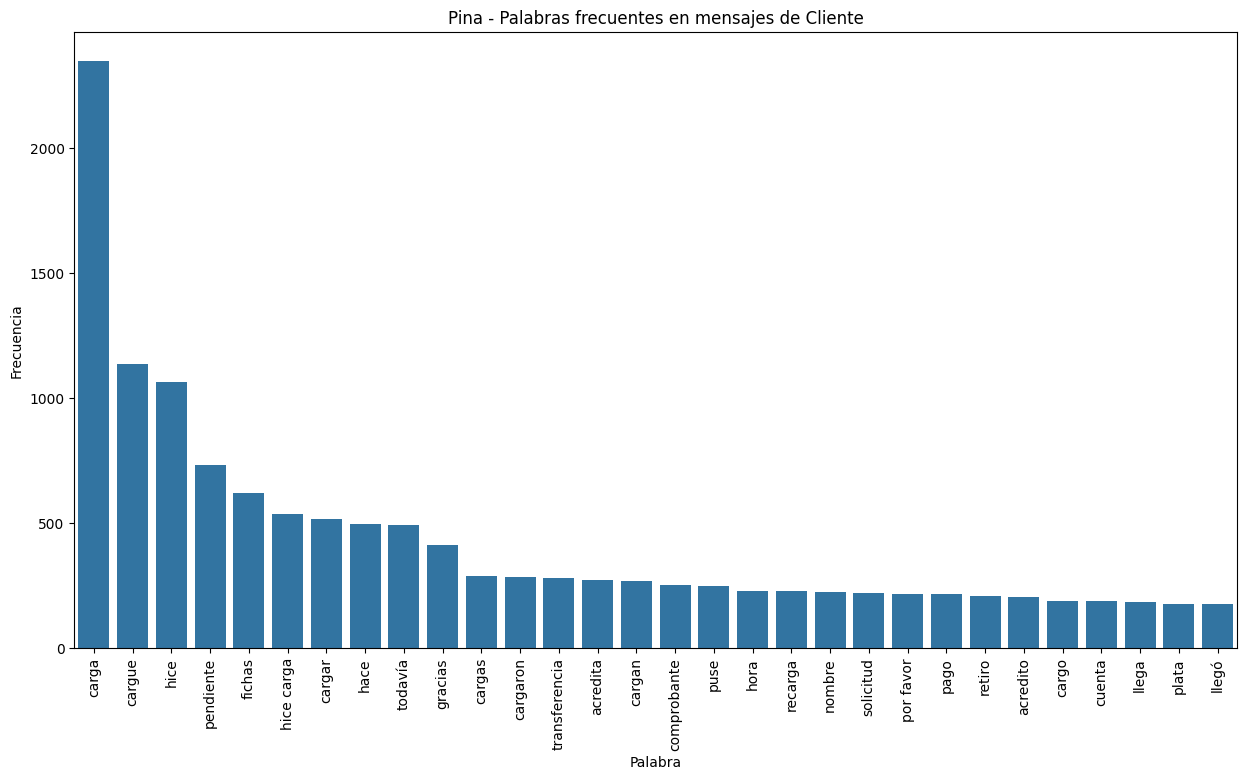

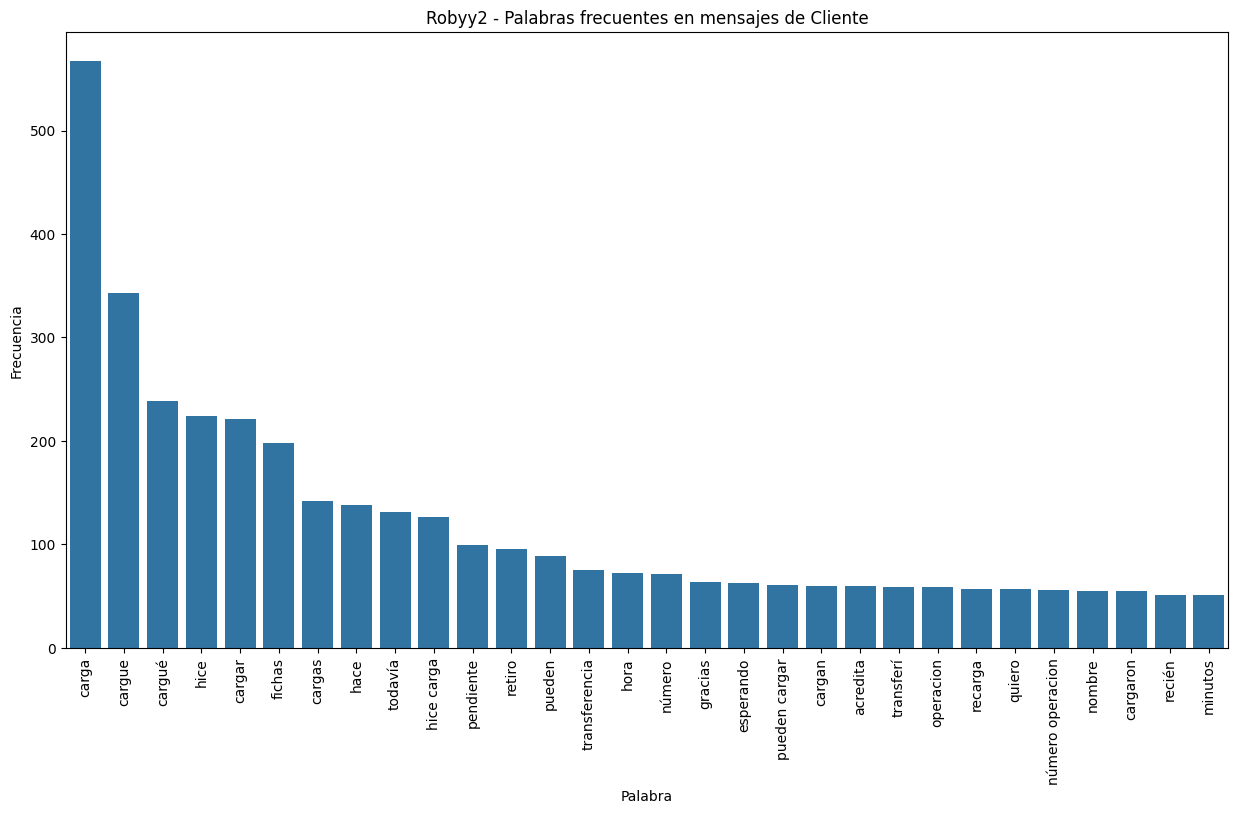

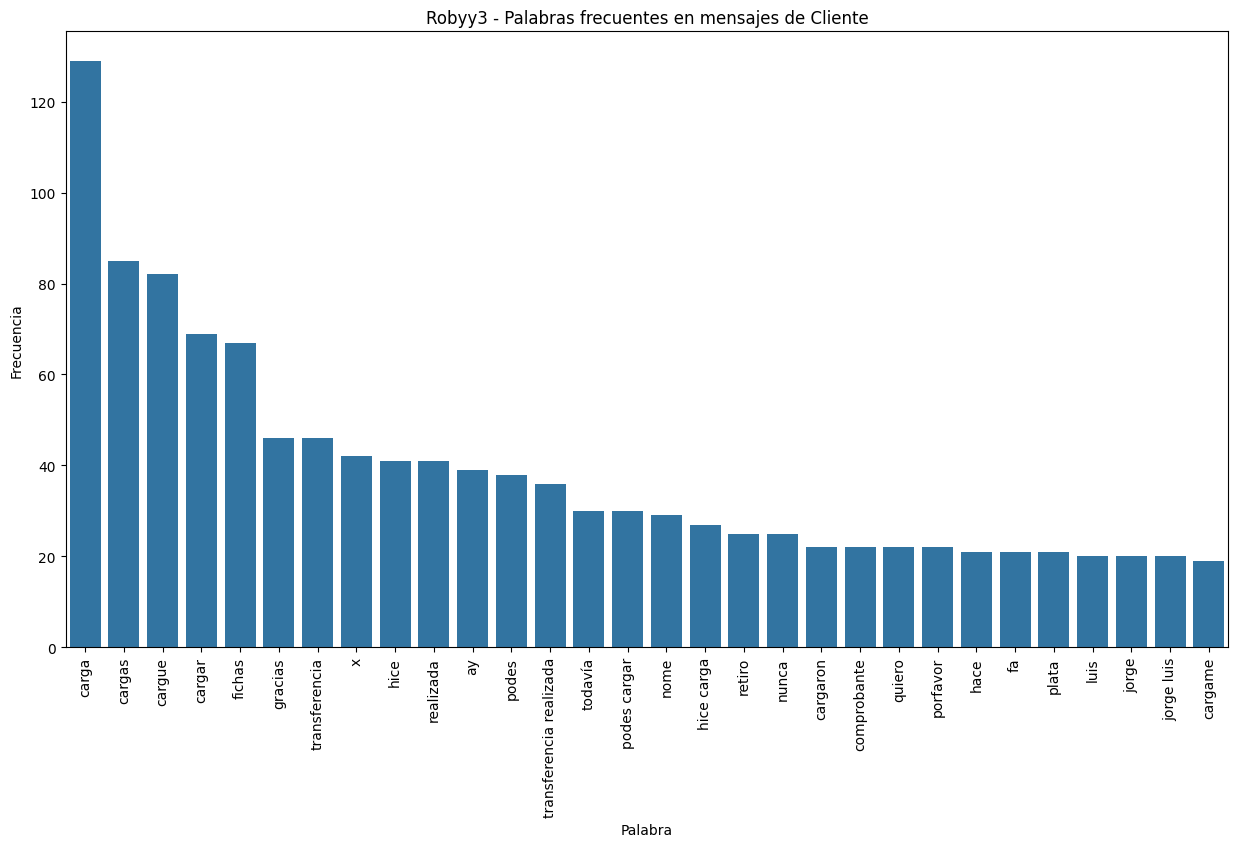

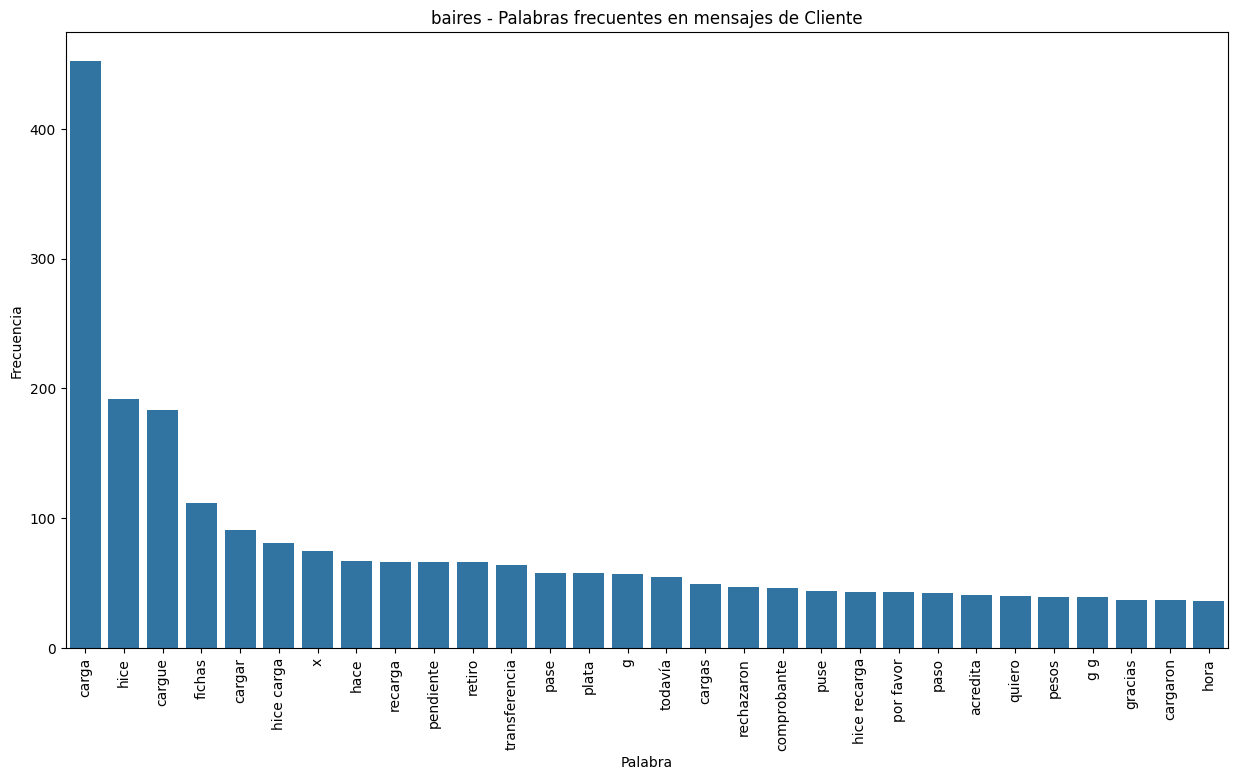

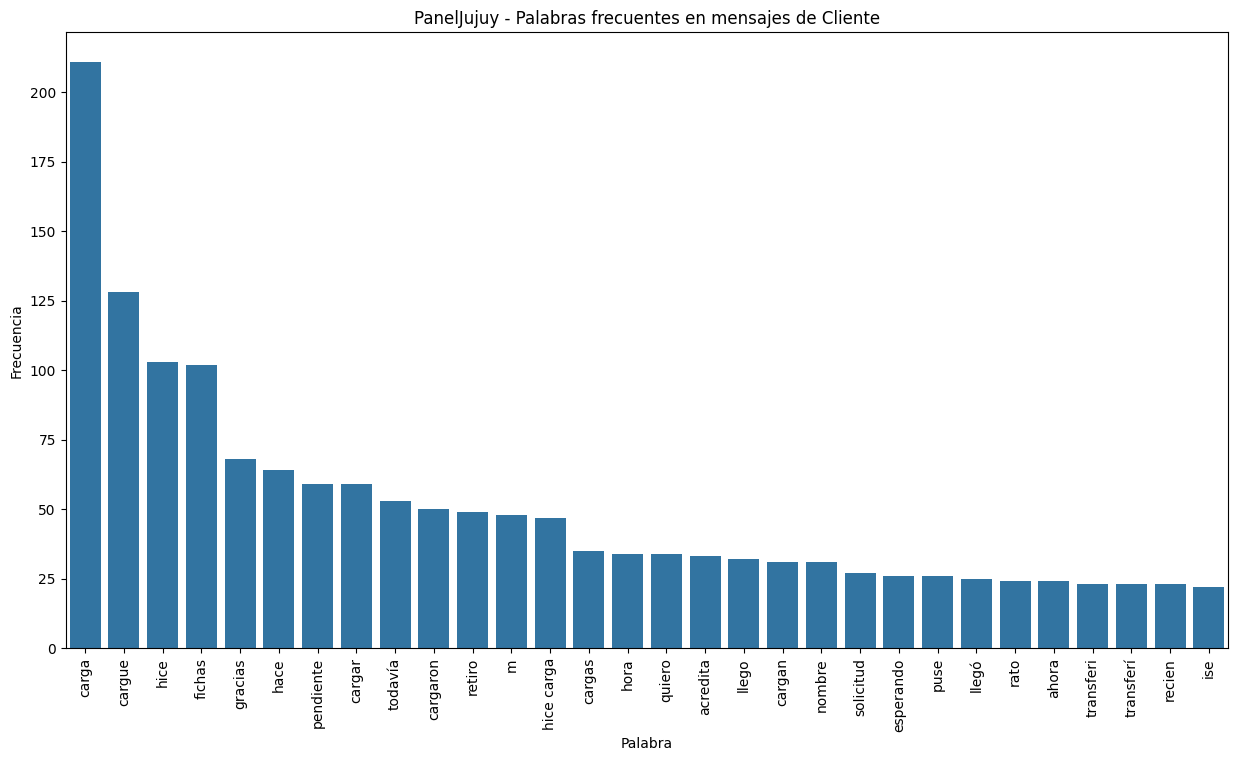

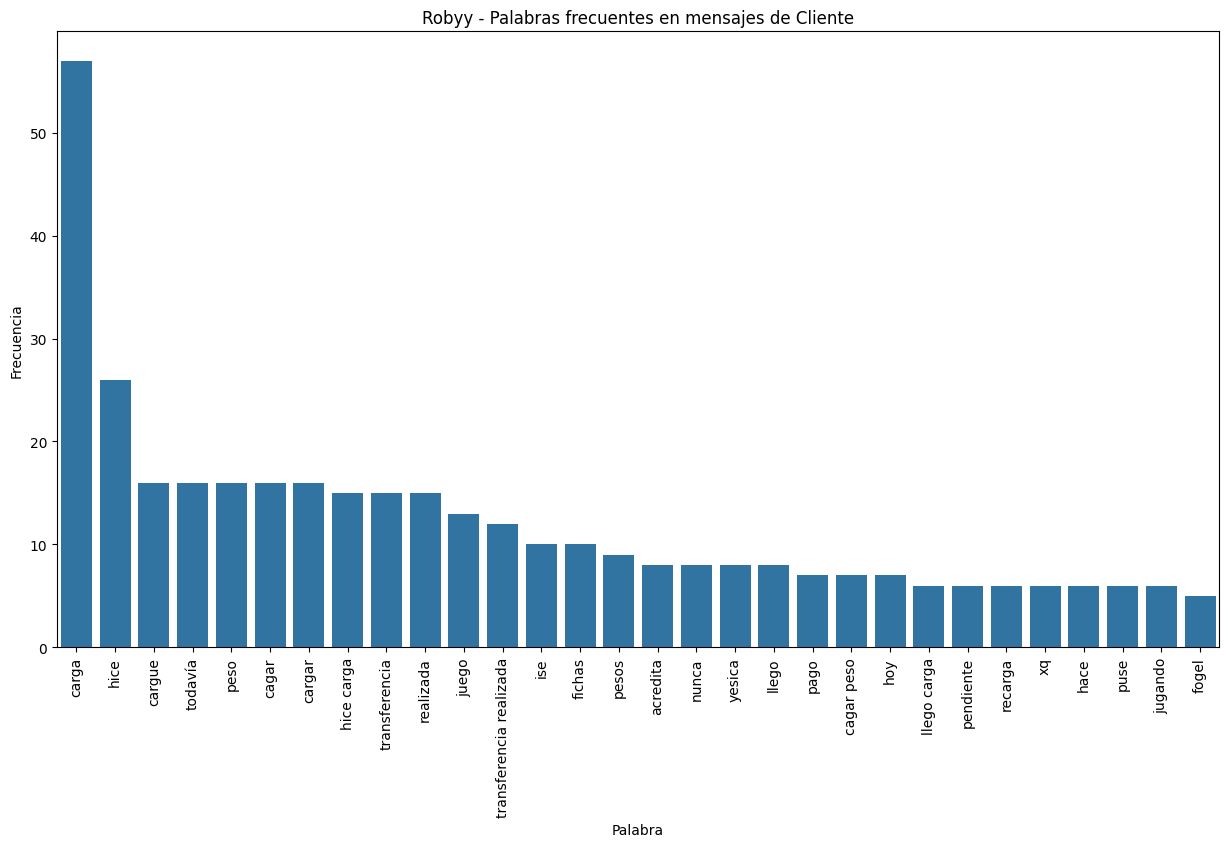

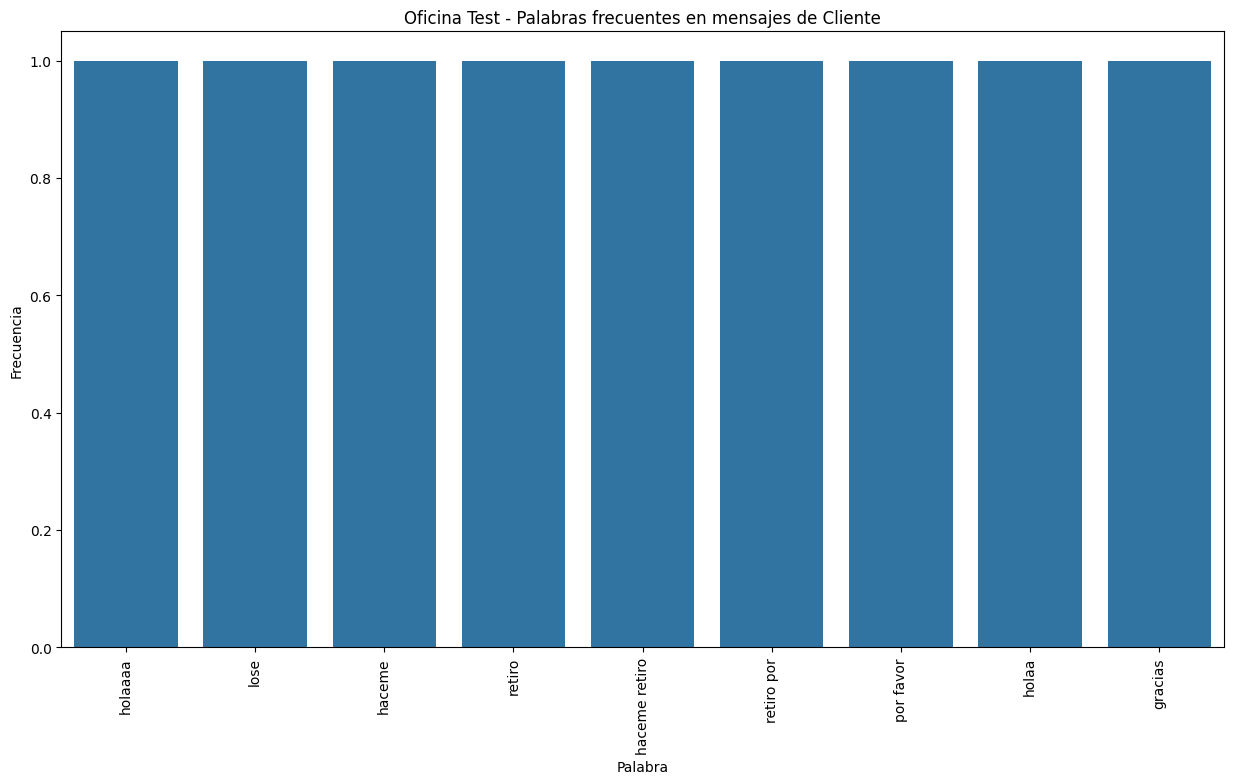

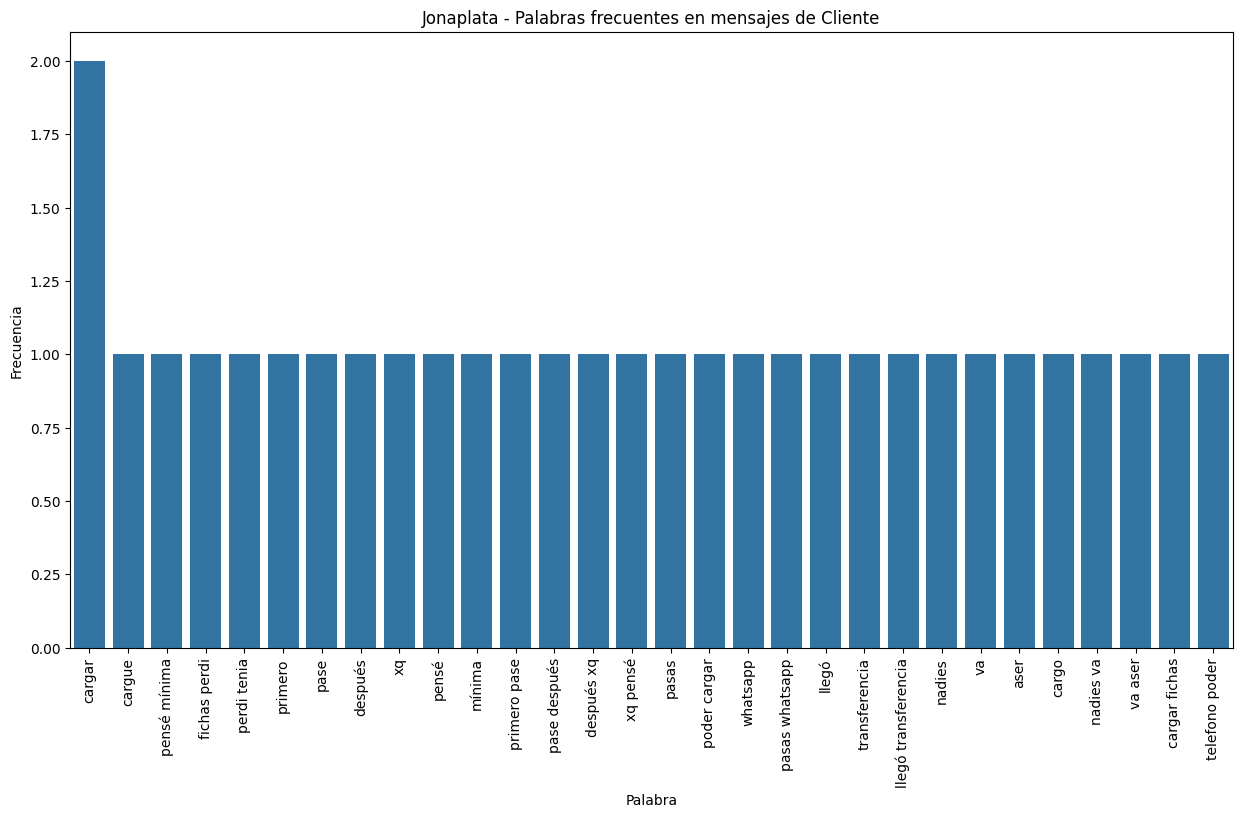

In [28]:
for id_oficina in df_mensajes.id_oficina.unique():
    df_mensajes_filtro = df_mensajes[(df_mensajes.origen == 'Cliente') & (df_mensajes.id_oficina == id_oficina) ].mensaje_stem
    ubicacion = ruta_imagenes  + 'oficina_' + str(id_oficina) + '/rpt_mensajes_cliente.png'
    oficina = df_mensajes[(df_mensajes.id_oficina == id_oficina)].oficina.unique()[0]
    genera_grafico(oficina + ' - Palabras frecuentes en mensajes de Cliente', df_mensajes_filtro, ubicacion)

In [92]:
lista_plana = [str(item) for sublista in mensajes_list for item in sublista]

In [93]:
mensajes_list_freq = nltk.FreqDist(lista_plana)

In [98]:
df_mensajes_list_freq = pd.DataFrame(list(mensajes_list_freq.items()), columns = ["Palabra","Frecuencia"])

In [100]:
df_mensajes_list_freq.sort_values('Frecuencia',ascending=False, inplace = True)

Palabra  Frecuencia
3             hola       13755
4           buenas        9651
12           carga        8252
73     comprobante        5854
80          fichas        4978
39       solicitud        4694
97   transferencia        3866
85          cargue        3804
26           favor        3704
2          gracias        3243
10            hice        2811
22          cargar        2468
236      pendiente        2392
5              mil        2145
9          titular        2020

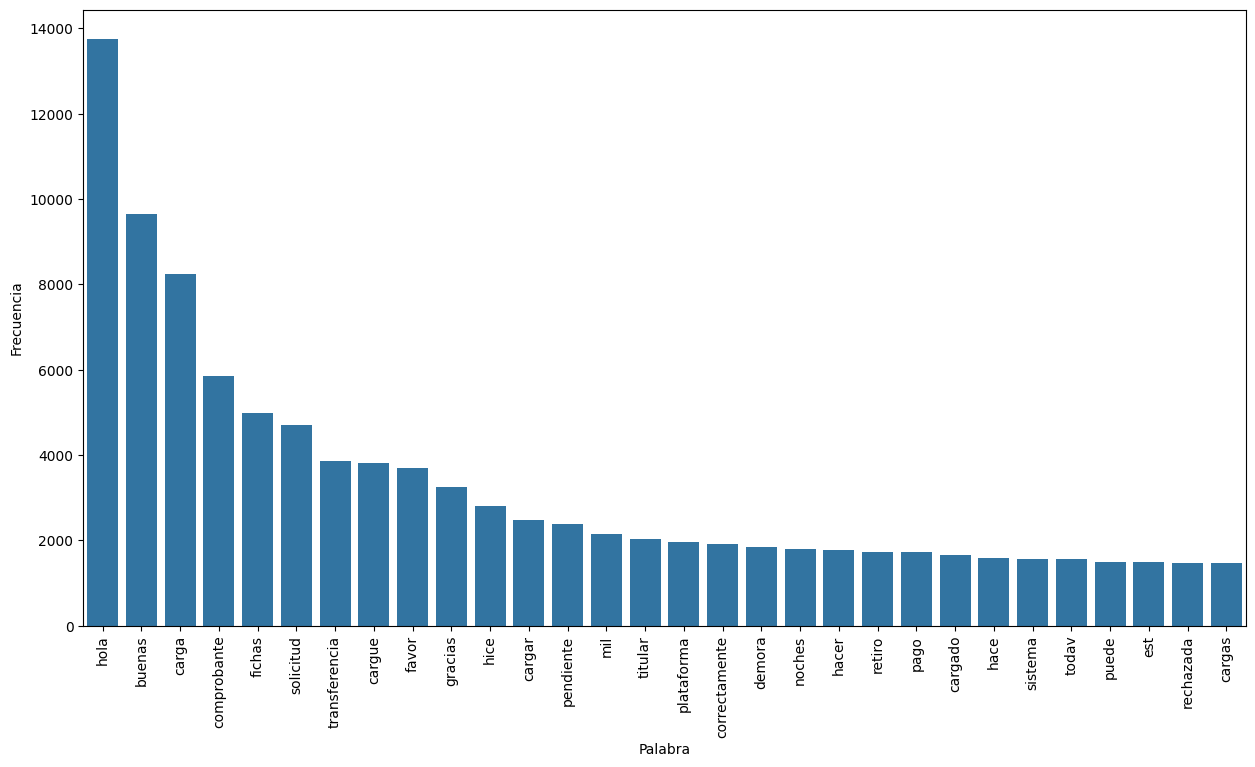

In [101]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_mensajes_list_freq.iloc[:30].Palabra, y = df_mensajes_list_freq.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
mensajes_list_plano = [' '.join([token.text for token in sublista]) for sublista in mensajes_list]

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features, ngram_range=(1,2))

matriz_mensajes = cou_vec.fit_transform(mensajes_list_plano)

# Tomamos las palabras
all_words = cou_vec.get_feature_names_out()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])